## AdaBoost (Adaptive Boosting)

Adaboost algorithm can be used for both classification and regression tasks.

For classification tasks, Adaboost provides more weights to misclassified observations on subsequent weak learners.

Note that other base learners like SVM or KNN etc. can be used as a base learner of AdaBoost. 

<b>By default, Adaboost algorithm uses decision trees with max depth of 1 as base learners.</b>

![image.png](https://www.researchgate.net/publication/356698772/figure/fig2/AS%3A1096436418641951%401638422221975/The-architecture-of-Gradient-Boosting-Decision-Tree.png)

<b>Assumptions of Adaptive Boosting</b>: Independence of observations

<b>Requirement of feature scaling: No</b>

<b>Robust to outliers: No</b>

<b>Is multicollinearity an issue?: No</b>

<b>Advantages of AdaBoost:</b>
1. Individual weak learners can be combined together to make a strong individual learner
2. Less hyperparameter tuning required
3. Helps to improve accuracy of weak classifiers
4. Can handle missing data
5. Less prone to overfitting

<b>Disadvantages of AdaBoost:</b>
1. Sensitive to noisy data and outliers, due to exponential loss function which strongly penalizes outlier points
2. Slightly longer training time than other boosting techniques

<b>Time complexity of model training: O(n * p * m)</b>

<b>Time complexity of model prediction: O(p*m)</b>

n - Number of training samples

p - Number of features

m - Number of decision trees
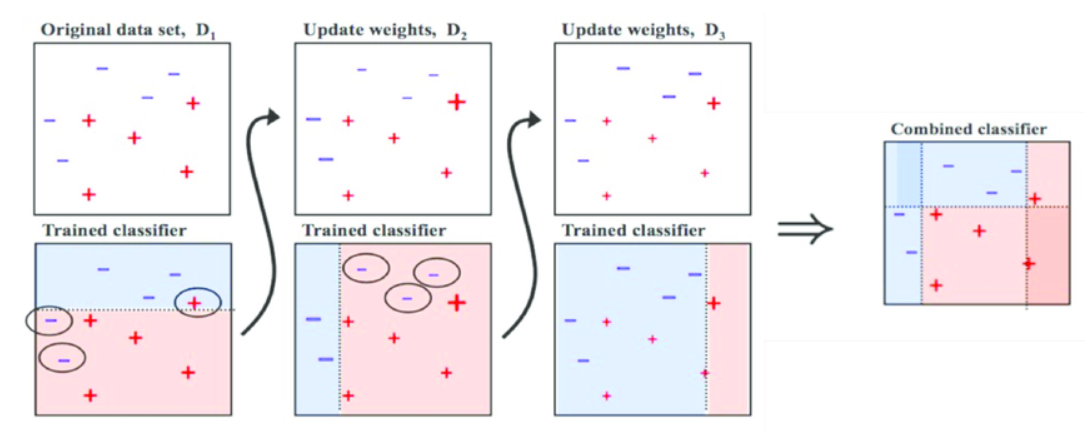

In [1]:
# Import all required Python libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, load_wine
from skopt import BayesSearchCV
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from skopt.space import Real, Integer, Categorical
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold
from transformers import OutlierCapTransformer

More details related to Exploratory Data Analysis for both regression and classification problem statement can be found in the following Jupyter Notebook within the same folder: EDA_Regression.ipynb and EDA_Classification.ipynb

## AdaBoost for regression

<b>Important hyperparameters for AdaBoostRegressor</b>:
1. learning_rate: Weight applied to each regressor at each boosting iteration. Higher learning rate increases contribution of each regressor. (Tradeoff between learning_rate and num_estimators values)
2. num_estimators: Maximum number of estimators before boosting algorithm terminates
3. loss: Loss function to use when updating the weights after each boosting iteration. (linear, square, exponential)

For regression tasks, Adaboost algorithm makes final prediction from test data by obtaining prediction values from every base learner and uses <b>simple averaging</b> to determine final prediction value.

## Steps of AdaBoost algorithm (Regression)

The following steps are involved in the AdaBoost algorithm for regression:

1) Equal weights are initially assigned to all rows of the dataset

2) Create a Decision Tree (Stump) for every feature of the dataset and select the first decision tree, which has the lowest average loss (linear, square or exponential). Note that stump in decision tree refers to having only one root node and two leaf nodes.

3) Compute confidence measure of predictor (low value indicates high confidence) using the following formula: 
<b>Confidence measure (B) = Average Loss / (1 - Average Loss)</b>

4) Change weights of each record using the following formula: <b>New weight = Old weight * B^(1 -  Loss of sample)</b>

5) Normalize updated weights by dividing individual weights with sum of updated weights

6) Assign buckets that contains range of weights values for all records based on updated weights.

7) Create a new sample dataset (<b>sampling with replacement</b>) with same size as original dataset based on random number selection between 0 and 1 that falls within a bucket associated to the record. Note that at this stage records that have higher loss will have higher chance of being sampled into the new dataset.

8) Repeat steps 1 to 7 for every iteration until reaching the end of the sequential model pipeline or average loss is less than 0.5.
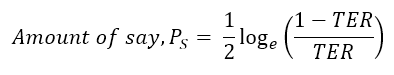
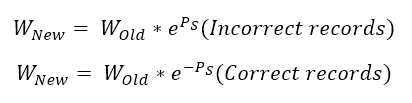

In [2]:
data = fetch_california_housing()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'Median House Value ($100000)'

In [3]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = KFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_rmse, test_rmse = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,
                               scoring= make_scorer(mean_squared_error, squared=False),refit=True, n_jobs=3)
        search.fit(X_train,y_train)
        val_rmse.append(search.best_score_)
        print(f'Validation RMSE for fold {fold+1}:',search.best_score_)
        print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
        y_pred = search.best_estimator_.predict(X_test)
        test_rmse.append(mean_squared_error(y_test,y_pred,squared=False))
        print(f'Test RMSE for fold {fold+1}:',mean_squared_error(y_test,y_pred,squared=False))
    print('----------------------')
    print('Average validation RMSE score:', np.mean(val_rmse))
    print('Average test RMSE score:', np.mean(test_rmse))

In [4]:
reg = AdaBoostRegressor(random_state=120)
pipeline = Pipeline(steps=[])
pipeline.steps.append(['outlier_capping',OutlierCapTransformer(X.columns.tolist())])
pipeline.steps.append(('regression',reg))
search_space = dict()
search_space['regression__learning_rate'] = Real(0.0001,1,'log-uniform')
search_space['regression__loss'] = Categorical(['linear','square','exponential'])
nested_cv(X, y, pipeline, search_space)

Validation RMSE for fold 1: 0.8130768119478482
Best hyperparameters for fold 1: OrderedDict([('regression__learning_rate', 0.0017761763440967023), ('regression__loss', 'exponential')])
Test RMSE for fold 1: 0.7653275004260491
Validation RMSE for fold 2: 0.9099676573576927
Best hyperparameters for fold 2: OrderedDict([('regression__learning_rate', 0.6528729527052108), ('regression__loss', 'exponential')])
Test RMSE for fold 2: 0.8916942547953132
Validation RMSE for fold 3: 0.9940958325171566
Best hyperparameters for fold 3: OrderedDict([('regression__learning_rate', 0.31858468964048386), ('regression__loss', 'square')])
Test RMSE for fold 3: 0.994431371746816
Validation RMSE for fold 4: 0.9721882997233123
Best hyperparameters for fold 4: OrderedDict([('regression__learning_rate', 0.2993932205004957), ('regression__loss', 'square')])
Test RMSE for fold 4: 1.0015863564722054
Validation RMSE for fold 5: 1.1494773884580611
Best hyperparameters for fold 5: OrderedDict([('regression__learning

## AdaBoost for Classification

<b>Important hyperparameters for AdaBoostClassifier</b>:
1. learning_rate: Weight applied to each classifier at each boosting iteration. Higher learning rate increases contribution of each classifier. (Tradeoff between learning_rate and num_estimators values)
2. num_estimators: Maximum number of estimators before boosting algorithm terminates
3. algorithm: Loss function to use when updating the weights after each boosting iteration. (SAMME vs SAMME.R)

<b>Difference between SAMME and SAMME.R</b>:
- SAMME.R uses probability estimates to update weights, while SAMME uses classification only.
- SAMME.R converges faster than SAMME, achieving lower test error with fewer boosting iterations.

<b>Methods to handle imbalanced dataset for classification</b>:
1. Assign class weights to model
2. Resampling techniques (Oversampling/Combination of Oversampling and Undersampling - Less suitable for larger datasets due to high computation time)
3. Assign sample_weight to fit method

For classification tasks, Adaboost algorithm makes final prediction from test data by obtaining class predictions from every base learner and uses <b>majority voting</b> to determine final class prediction.

<img src = "https://www.researchgate.net/publication/324014302/figure/fig2/AS:644424015040514@1530654066950/Majority-voting-algorithm.png" width="400">

## Steps of AdaBoost algorithm (Classification)

The following steps are involved in the AdaBoost algorithm for classification:

1) Equal weights are initially assigned to all rows of the dataset

2) Create a Decision Tree (Stump) for every feature of the dataset and select the first decision tree, which has the lowest gini impurity index/entropy. Note that stump in decision tree refers to having only one root node and two leaf nodes.

3) Compute total error rate using the following formula: <b>Total Error Rate (TER) = Sum of weights associated with incorrectly classified records</b>

4) Compute performance of stump using the following formula:

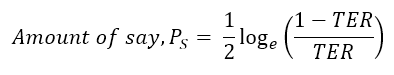

5) Change weights of each record using the following formula:

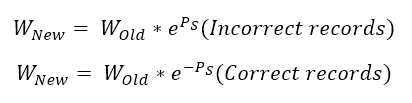

6) Normalize updated weights by dividing individual weights with sum of updated weights

7) Assign buckets that contains range of weights values for all records based on updated weights.

8) Create a new sample dataset (<b>sampling with replacement</b>) with same size as original dataset based on random number selection between 0 and 1 that falls within a bucket associated to the record. Note that at this stage records that are incorrectly classified will have higher chance of being sampled into the new dataset.

9) Repeat steps 1 to 8 for every iteration until reaching the end of the sequential model pipeline.

In [5]:
data = load_wine()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'Wine_Class'

In [6]:
X.nunique()

alcohol                         126
malic_acid                      133
ash                              79
alcalinity_of_ash                63
magnesium                        53
total_phenols                    97
flavanoids                      132
nonflavanoid_phenols             39
proanthocyanins                 101
color_intensity                 132
hue                              78
od280/od315_of_diluted_wines    122
proline                         121
dtype: int64

In [7]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_f1, test_f1 = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
        search.fit(X_train,y_train)
        val_f1.append(search.best_score_)
        print(f'Validation F1 score for fold {fold+1}:',search.best_score_)
        print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
        y_pred = search.best_estimator_.predict(X_test)
        test_f1.append(f1_score(y_test,y_pred, average='macro'))
        print(f'Test F1 score for fold {fold+1}:',f1_score(y_test,y_pred, average='macro'))
        print()
        cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        cmd.ax_.set_title(f"Confusion Matrix - AdaBoostClassifier (Fold {fold+1})")
        plt.grid(False)
        plt.show()
        print()
    print('----------------------')
    print('Average validation F1 score:', np.mean(val_f1))
    print('Average test F1 score:', np.mean(test_f1))

Validation F1 score for fold 1: 0.9124733600580281
Best hyperparameters for fold 1: OrderedDict([('classification__learning_rate', 0.7839370948864213)])
Test F1 score for fold 1: 0.9407407407407408



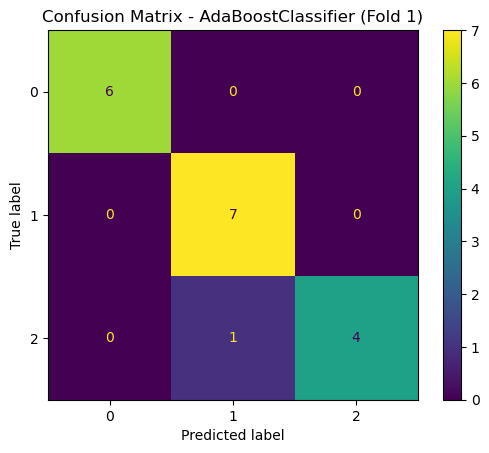


Validation F1 score for fold 2: 0.930305617171921
Best hyperparameters for fold 2: OrderedDict([('classification__learning_rate', 0.4148345462694245)])
Test F1 score for fold 2: 1.0



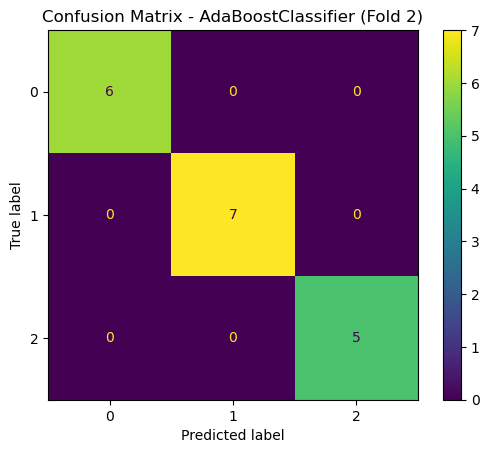


Validation F1 score for fold 3: 0.9155749423763065
Best hyperparameters for fold 3: OrderedDict([('classification__learning_rate', 0.5005461808335557)])
Test F1 score for fold 3: 0.9487179487179486



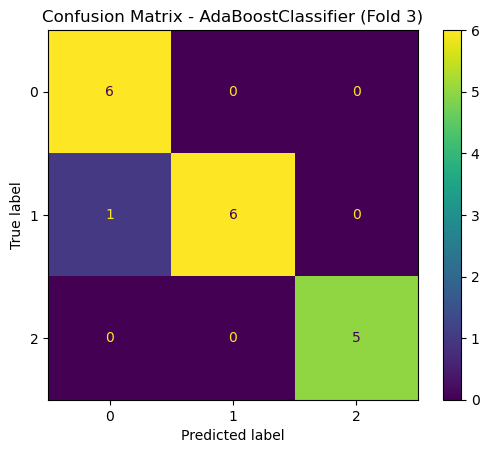


Validation F1 score for fold 4: 0.8909374548522621
Best hyperparameters for fold 4: OrderedDict([('classification__learning_rate', 0.020629865386248426)])
Test F1 score for fold 4: 1.0



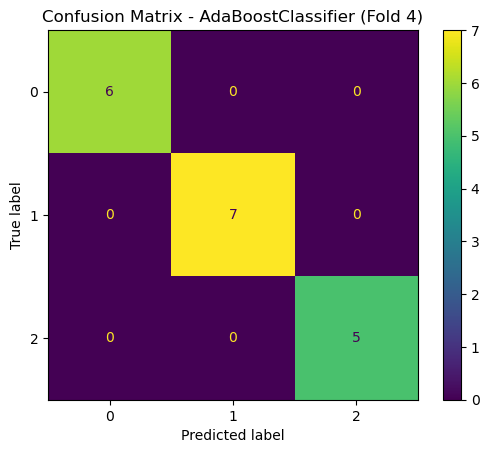


Validation F1 score for fold 5: 0.9159566326228011
Best hyperparameters for fold 5: OrderedDict([('classification__learning_rate', 0.4947491505860603)])
Test F1 score for fold 5: 1.0



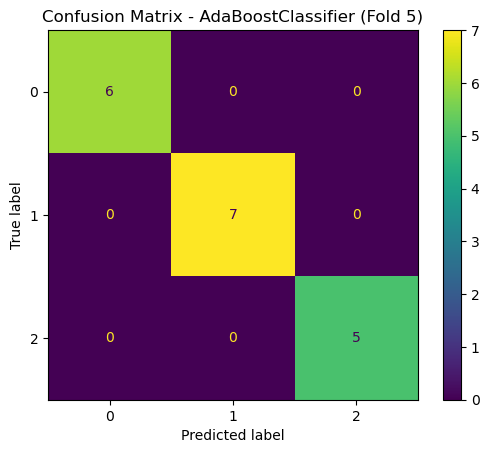


Validation F1 score for fold 6: 0.8743361356839617
Best hyperparameters for fold 6: OrderedDict([('classification__learning_rate', 0.010853585909553605)])
Test F1 score for fold 6: 0.9440559440559441



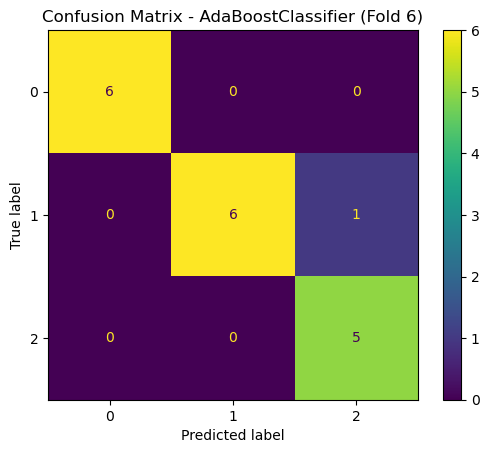


Validation F1 score for fold 7: 0.8899664173399696
Best hyperparameters for fold 7: OrderedDict([('classification__learning_rate', 0.10708231514819085)])
Test F1 score for fold 7: 0.775925925925926



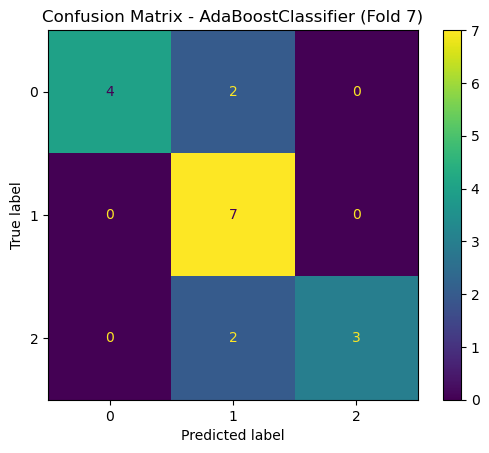


Validation F1 score for fold 8: 0.9428819723107873
Best hyperparameters for fold 8: OrderedDict([('classification__learning_rate', 0.5358257428526517)])
Test F1 score for fold 8: 0.9474747474747475



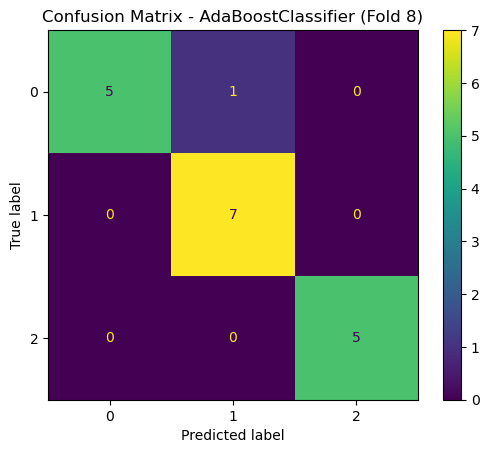


Validation F1 score for fold 9: 0.9415020519215791
Best hyperparameters for fold 9: OrderedDict([('classification__learning_rate', 0.07029581594813329)])
Test F1 score for fold 9: 0.8850408850408851



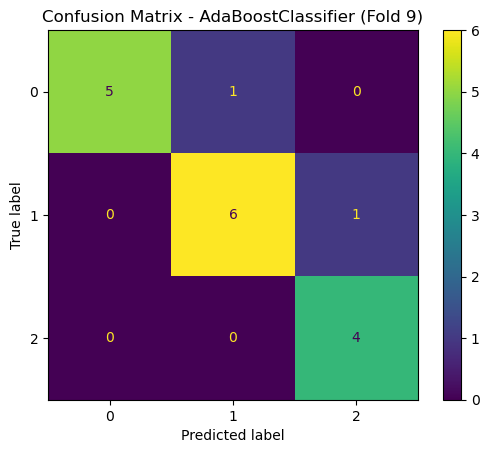


Validation F1 score for fold 10: 0.91247767640445
Best hyperparameters for fold 10: OrderedDict([('classification__learning_rate', 0.8344127344316788)])
Test F1 score for fold 10: 1.0



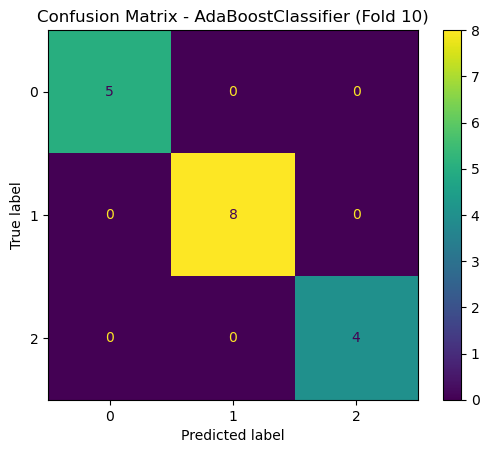


----------------------
Average validation F1 score: 0.9126412260742066
Average test F1 score: 0.9441956191956192


In [8]:
clf = AdaBoostClassifier(random_state=120)
pipeline = Pipeline(steps=[])
pipeline.steps.append(['outlier_capping',OutlierCapTransformer(X.columns.tolist())])
pipeline.steps.append(('classification',clf))
search_space = dict()
search_space['classification__learning_rate'] = Real(0.0001,1,'log-uniform')
nested_cv(X, y, pipeline, search_space)

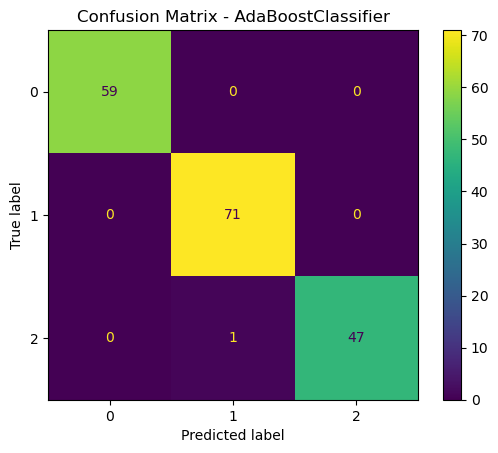

In [9]:
search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10, scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
search.fit(X,y)
y_pred = search.best_estimator_.predict(X)
cmd = ConfusionMatrixDisplay.from_predictions(y, y_pred)
cmd.ax_.set_title("Confusion Matrix - AdaBoostClassifier")
plt.grid(False)
plt.show()